## Yield Optimization via Hybrid ML-Bayesian for 1D Feature Space

In [115]:
import numpy as np
import pandas as pd

import tensorflow
import autokeras as ak

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [117]:
class TrainingPlot(tensorflow.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('mean_squared_error'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_mean_squared_error'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            #plt.figure()
            #subplot(nrows, ncols, plot_number) 
            plt.figure(figsize=(15,6))
            plt.subplot(121)
            plt.title("Training Loss [Epoch {}]".format(epoch))
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss")
            plt.legend()
            
            plt.subplot(122)
            plt.title("Training Accuracy [Epoch {}]".format(epoch))
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.xlabel("Epoch #")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [148]:
X = np.linspace(-2, 10, 10000)

def f(x, noise): return np.exp(-(x - 2) ** 2) + np.exp(-(x - 6) ** 2 / 10) + 1/ (x ** 2 + 1) + noise * np.random.randn(*x.shape)


y = f(X, 0)

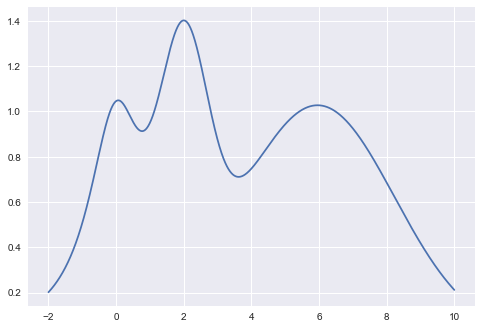

In [149]:
plt.plot(X, y);

## Data

In [151]:
df = pd.DataFrame(columns=['X','y'], dtype=float)

In [152]:
df['X'] = X.reshape(-1, )
df['y'] = y.reshape(-1, ) 

df['X'] = df['X'].astype(float)
df['y'] = df['y'].astype(float)

In [153]:
print(df.head())

        X         y
0 -2.0000  0.201662
1 -1.9988  0.201857
2 -1.9976  0.202053
3 -1.9964  0.202248
4 -1.9952  0.202445


In [154]:
df.describe()

,X,y
count,10000.000000,10000.000000
mean,4.000000,0.812304
std,3.464621,0.297530
min,-2.000000,0.201662
25%,1.000000,0.627394
50%,4.000000,0.876684
75%,7.000000,1.008198
max,10.000000,1.401897


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       10000 non-null  float64
 1   y       10000 non-null  float64
dtypes: float64(2)
memory usage: 156.4 KB


## Prediction NN Algorithm

In [157]:
# normalize the input data
X = df['X'].values
y = df['y'].values

X_norm = X #(X - X.mean()) / X.std()
y_norm = y #(y - y.mean()) / y.std()


x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

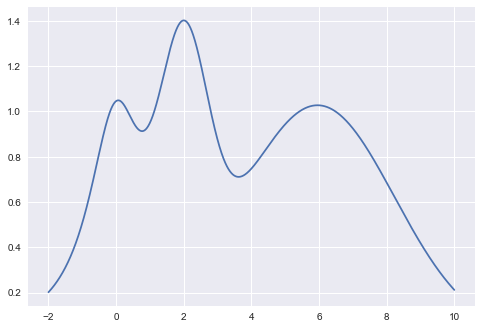

In [158]:
plt.plot(X_norm, y_norm);

In [159]:
y_norm.max()

1.4018970892014762

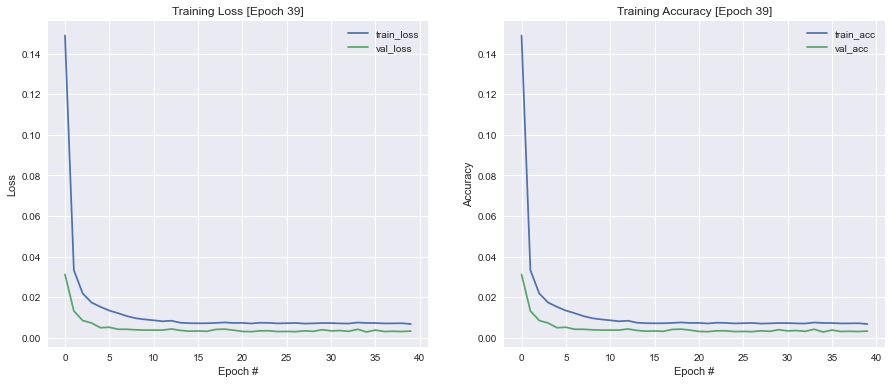

250/250 [==============================] - 1s 4ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets


In [160]:
# define the search
search = ak.StructuredDataRegressor(max_trials=5)

# perform the search
history =  search.fit(x=x_train.reshape(-1,1), 
                      y=y_train.reshape(-1,1),
                      validation_data= (x_test.reshape(-1,1), y_test.reshape(-1,1)),
                      callbacks=[plot_losses], 
                      epochs = 40,
                      verbose=1)

In [161]:
loss, acc = search.evaluate(x_test, y_test, verbose=1)
print('Accuracy: %.4f' % acc)

63/63 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Accuracy: 0.0034


In [162]:
# get the best performing model
model = search.export_model()

# summarize the loaded model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 1)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                64        
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [163]:
from sklearn.metrics import r2_score
r2_score(y_test, model.predict(x_test))

0.961047932073655

In [164]:
tp_indx = 4
print(f"real value: {y_test[tp_indx]}, model predicted: {model.predict(x_test[tp_indx].reshape(1,-1))}")

real value: 0.7249632301243275, model predicted: [[0.7245921]]


## Bayesian Optimization


In [165]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    # acq.set_xlim((-2, 2))
    # axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    # acq.set_xlim((-2, 2))
    # acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [182]:
def wrapper(x, *args) -> float:
    
    network_input = x.reshape(1,-1)
    network_output = model.predict(network_input, *args)
    bo = float(network_output)
    
    if (bo > -10) & (bo < 10):
        return bo
    
    else:
        return 10000000

In [183]:
def bo_run(x, y, wrapper, pbounds, n_iter=10, kappa=5, xi=None, random_state=None):

    bo = BayesianOptimization(wrapper, pbounds, verbose=2)

    bo.maximize(init_points=2, n_iter=n_iter, acq='ucb', kappa=kappa)
    plot_gp(bo, x.reshape(-1,1 ), y);

    utility = UtilityFunction(kind="ucb", kappa=kappa, xi=0)
    next_point_to_probe = bo.suggest(utility)

    print(f"Next Point to Probe: {next_point_to_probe}")
    print(f"Optimal Point: {bo.max}")


|   iter    |  target   |     x     |
-------------------------------------
|  1        |  1.164    |  1.195    |
|  2        |  0.3681   |  9.197    |
|  3        |  0.8379   |  7.367    |
|  4        |  1.165    |  1.2      |
|  5        |  0.7699   |  4.1      |
|  6        |  0.286    | -2.0      |
|  7        |  1.007    |  5.799    |
|  8        |  1.133    |  2.599    |
|  9        |  0.8615   | -0.234    |
|  10       |  1.324    |  1.951    |
|  11       |  0.9823   |  6.534    |
|  12       |  1.276    |  1.726    |
|  13       |  0.9314   |  5.003    |
|  14       |  0.1993   |  9.999    |
|  15       |  1.362    |  2.182    |
|  16       |  0.6267   |  8.203    |
|  17       |  1.002    |  0.4308   |
|  18       |  0.5964   | -1.012    |
|  19       |  1.322    |  2.276    |
|  20       |  0.742    |  3.347    |
|  21       |  1.355    |  2.097    |
|  22       |  0.9953   |  5.41     |
|  23       |  0.9338   |  6.931    |
|  24       |  1.077    |  0.7859   |
|  25       

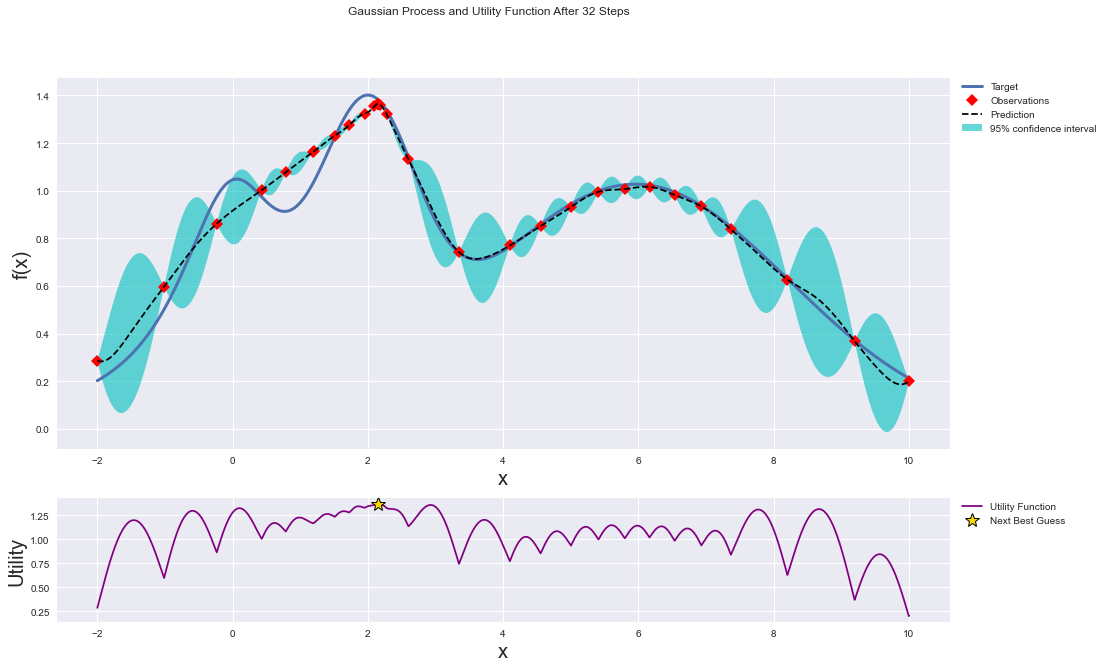

In [185]:
pbounds = {'x': (-2, 10)}
bo_run(X, y, wrapper, pbounds, n_iter=30, kappa=5, xi=None, random_state=None)